# CSE603: Machine Learning - II

# Assignment 2

### Submitted by:
#### Name      : Muhammad Amin Ghias
#### ERP ID    : 25366

Date : 16th October 2022

# Imprting Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import multivariate_normal


from scipy import stats
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

import lazypredict

from lazypredict.Supervised import LazyRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV, cross_val_score

from sklearn.preprocessing import MinMaxScaler



pd.set_option("display.precision", 8)

NumExpr defaulting to 8 threads.


## DataFrame

In [2]:
df_original=pd.read_csv('hour.csv')
print(df_original.shape)
print(df_original.columns)
df_original.head()

(17379, 17)
Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.29,0.81,0.00,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.27,0.80,0.00,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.27,0.80,0.00,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.29,0.75,0.00,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.29,0.75,0.00,0,1,1


## About dataset: 

This dataset  is of Bike Sharing Dataset Data Set taken from UCI- Machine Learning repository

url

https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

In [3]:
df=df_original.copy()

In [4]:
print(df.shape)
print(df.dtypes)
df.isna().sum()

(17379, 17)
instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object


instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [5]:
d= df.dtypes == object
c=d[d== True]
c.index[0]

'dteday'

In [6]:
df=df.drop(columns=c.index[0])

In [7]:
df=df.astype(float)
df.dtypes

instant       float64
season        float64
yr            float64
mnth          float64
hr            float64
holiday       float64
weekday       float64
workingday    float64
weathersit    float64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual        float64
registered    float64
cnt           float64
dtype: object

## Feature Selection 

(17379, 15)


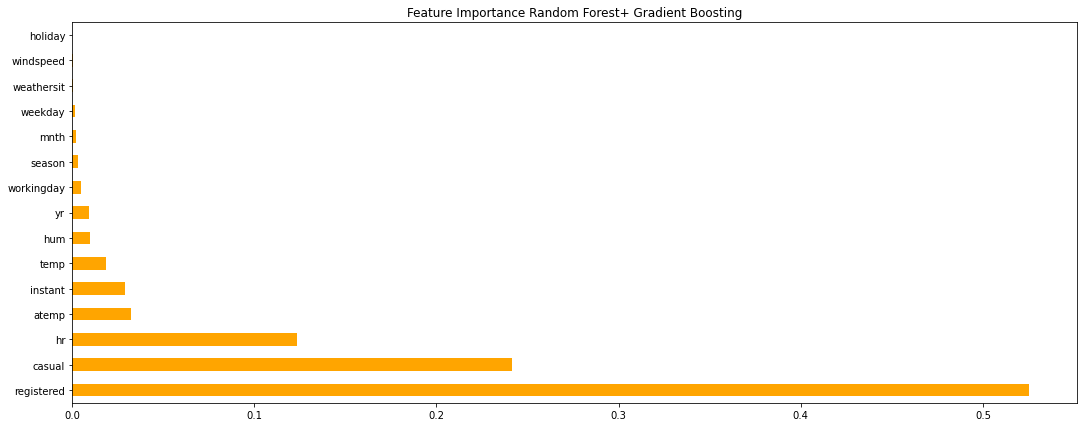

Index(['registered', 'casual', 'hr', 'atemp', 'instant', 'temp', 'hum', 'yr',
       'cnt'],
      dtype='object')


In [8]:
X=df.drop(columns='cnt')
print(X.shape)
y= df.cnt


trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.3, random_state=2)
    
    
clfRF = RandomForestRegressor(max_depth=5, max_features=4, min_samples_split=8,
                n_estimators=100)#, random_state=0)
clfRF.fit(trainX, trainy)
importance_rf = pd.Series(clfRF.feature_importances_, index=trainX.columns)
    

clfGB = GradientBoostingRegressor(max_depth=2,n_estimators=50)#, random_state=0)
clfGB.fit(trainX, trainy)
importance_GB = pd.Series(clfGB.feature_importances_, index=trainX.columns)

importance_sorted = importance_GB + importance_rf

importance_sorted = importance_rf.sort_values()


plt.figure(figsize=(18, 7))
importance_sorted.nlargest(20).plot(kind='barh', color='orange')

plt.title("Feature Importance Random Forest+ Gradient Boosting")
plt.show()


z= int(0.5*len(df.columns))
z

b=importance_sorted.nlargest(z)

col = list(b.index)

col.append('cnt')
col

dfr =df[col]

print(dfr.columns)

### Chose the best 50% features

# EDA on the best features dataset

In [9]:
dfr.head()

,registered,casual,hr,atemp,instant,temp,hum,yr,cnt
0,13.00,3.00,0.00,0.29,1.00,0.24,0.81,0.00,16.00
1,32.00,8.00,1.00,0.27,2.00,0.22,0.80,0.00,40.00
2,27.00,5.00,2.00,0.27,3.00,0.22,0.80,0.00,32.00
3,10.00,3.00,3.00,0.29,4.00,0.24,0.75,0.00,13.00
4,1.00,0.00,4.00,0.29,5.00,0.24,0.75,0.00,1.00


In [10]:
dfr.shape


(17379, 9)

### Checking distplot of all remaining Features

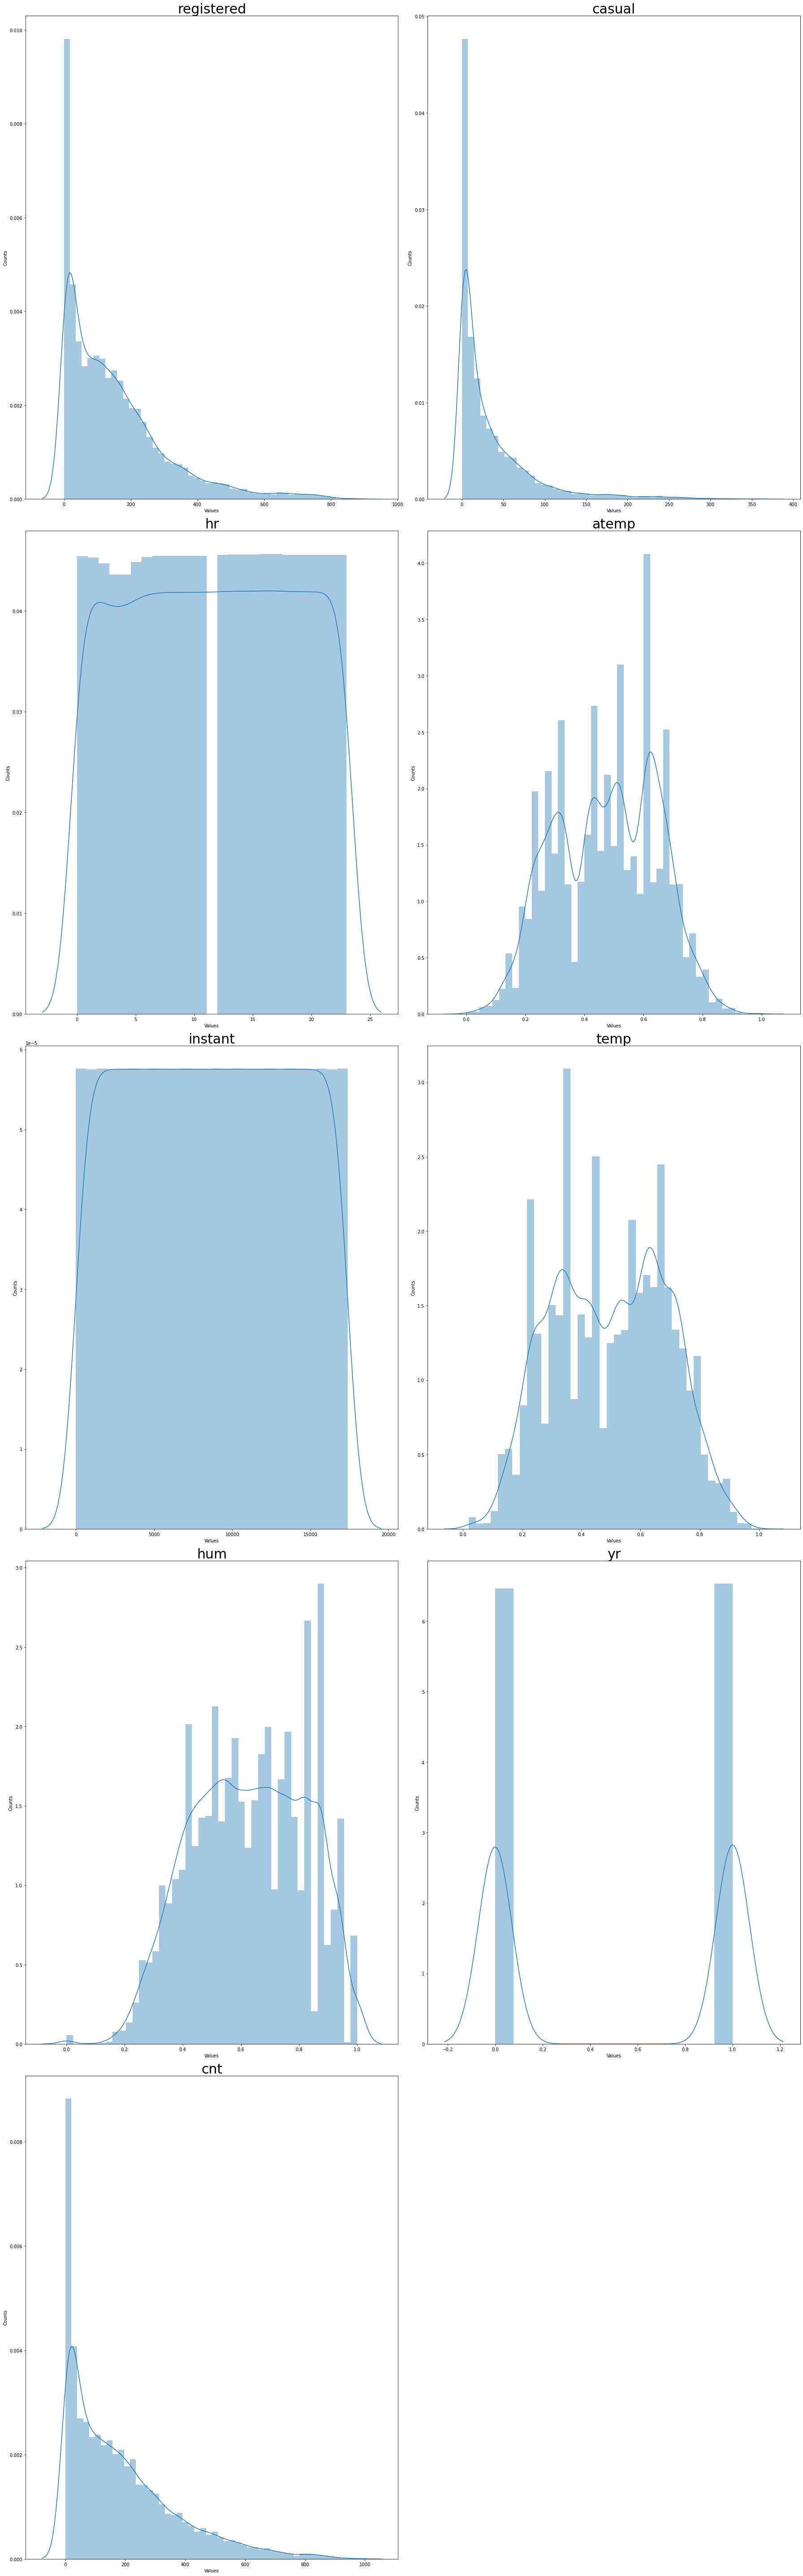

In [11]:
k=int(len(dfr.columns)/2)+1

plt.figure(figsize=(25, 80))

for i, col in enumerate(dfr.columns):

    plt.subplot(k, 2, i+1)
    try:
        sns.distplot(dfr[col])
        # plt.hist(dfr[col])
        plt.tight_layout()
        plt.title(col,size=30)
        plt.xlabel("Values")
        plt.ylabel("Counts")
    except:
        print(col)

### yr distribution is not close to normal, whereas other columns distribution is skewed and somewaht normala gaussian

#### Removing yr also

In [12]:
print(dfr.shape)
df_n=dfr.drop(columns='yr')
print(df_n.shape)

(17379, 9)
(17379, 8)


In [13]:
df_s=df_n.copy()

In [14]:
df_s.head()

,registered,casual,hr,atemp,instant,temp,hum,cnt
0,13.00,3.00,0.00,0.29,1.00,0.24,0.81,16.00
1,32.00,8.00,1.00,0.27,2.00,0.22,0.80,40.00
2,27.00,5.00,2.00,0.27,3.00,0.22,0.80,32.00
3,10.00,3.00,3.00,0.29,4.00,0.24,0.75,13.00
4,1.00,0.00,4.00,0.29,5.00,0.24,0.75,1.00


### Scaling dataset

In [15]:
# from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X2_Scaled = scaler.fit_transform(df_s)
df_n = pd.DataFrame(X2_Scaled)
df_n.columns = df_s.columns
df_n.head()

,registered,casual,hr,atemp,instant,temp,hum,cnt
0,0.01,0.01,0.00,0.29,0.00,0.22,0.81,0.02
1,0.04,0.02,0.04,0.27,0.00,0.20,0.80,0.04
2,0.03,0.01,0.09,0.27,0.00,0.20,0.80,0.03
3,0.01,0.01,0.13,0.29,0.00,0.22,0.75,0.01
4,0.00,0.00,0.17,0.29,0.00,0.22,0.75,0.00


In [16]:
df_n.cnt.value_counts()

0.00    260
0.01    236
0.00    231
0.00    224
0.00    208
       ... 
0.89      1
0.76      1
0.88      1
0.77      1
0.85      1
Name: cnt, Length: 869, dtype: int64

# Finding probabbilties of all columns and joint probabilty

In [17]:
df_s.head()

,registered,casual,hr,atemp,instant,temp,hum,cnt
0,13.00,3.00,0.00,0.29,1.00,0.24,0.81,16.00
1,32.00,8.00,1.00,0.27,2.00,0.22,0.80,40.00
2,27.00,5.00,2.00,0.27,3.00,0.22,0.80,32.00
3,10.00,3.00,3.00,0.29,4.00,0.24,0.75,13.00
4,1.00,0.00,4.00,0.29,5.00,0.24,0.75,1.00


In [18]:
df_s.describe()

,registered,casual,hr,atemp,instant,temp,hum,cnt
count,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00
mean,153.79,35.68,11.55,0.48,8690.00,0.50,0.63,189.46
std,151.36,49.31,6.91,0.17,5017.03,0.19,0.19,181.39
min,0.00,0.00,0.00,0.00,1.00,0.02,0.00,1.00
25%,34.00,4.00,6.00,0.33,4345.50,0.34,0.48,40.00
50%,115.00,17.00,12.00,0.48,8690.00,0.50,0.63,142.00
75%,220.00,48.00,18.00,0.62,13034.50,0.66,0.78,281.00
max,886.00,367.00,23.00,1.00,17379.00,1.00,1.00,977.00


In [19]:
df_n.describe()

,registered,casual,hr,atemp,instant,temp,hum,cnt
count,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00
mean,0.17,0.10,0.50,0.48,0.50,0.49,0.63,0.19
std,0.17,0.13,0.30,0.17,0.29,0.20,0.19,0.19
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.04,0.01,0.26,0.33,0.25,0.33,0.48,0.04
50%,0.13,0.05,0.52,0.48,0.50,0.49,0.63,0.14
75%,0.25,0.13,0.78,0.62,0.75,0.65,0.78,0.29
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [20]:
df_n.head()

,registered,casual,hr,atemp,instant,temp,hum,cnt
0,0.01,0.01,0.00,0.29,0.00,0.22,0.81,0.02
1,0.04,0.02,0.04,0.27,0.00,0.20,0.80,0.04
2,0.03,0.01,0.09,0.27,0.00,0.20,0.80,0.03
3,0.01,0.01,0.13,0.29,0.00,0.22,0.75,0.01
4,0.00,0.00,0.17,0.29,0.00,0.22,0.75,0.00


#### Findining probabilities of all columns

In [21]:
df_n.dtypes

registered    float64
casual        float64
hr            float64
atemp         float64
instant       float64
temp          float64
hum           float64
cnt           float64
dtype: object

In [22]:
df_n_prob=df_n.copy()

def f1(b):
    
    k=df_n[df_n[i] == b].shape[0]
    return(k/len(df_n))

for i in df_n.columns:
    df_n_prob['prob_'+i] = df_n[i].apply(f1)

df_n_prob.head()

,registered,casual,hr,atemp,instant,temp,hum,cnt,prob_registered,prob_casual,prob_hr,prob_atemp,prob_instant,prob_temp,prob_hum,prob_cnt
0,0.01,0.01,0.00,0.29,0.00,0.22,0.81,0.02,0.01,0.04,0.04,0.03,0.00,0.03,0.02,0.01
1,0.04,0.02,0.04,0.27,0.00,0.20,0.80,0.04,0.00,0.02,0.04,0.02,0.00,0.02,0.01,0.00
2,0.03,0.01,0.09,0.27,0.00,0.20,0.80,0.03,0.00,0.03,0.04,0.02,0.00,0.02,0.01,0.00
3,0.01,0.01,0.13,0.29,0.00,0.22,0.75,0.01,0.01,0.04,0.04,0.03,0.00,0.03,0.01,0.01
4,0.00,0.00,0.17,0.29,0.00,0.22,0.75,0.00,0.01,0.09,0.04,0.03,0.00,0.03,0.01,0.01


In [23]:
df_n_prob.head()

,registered,casual,hr,atemp,instant,temp,hum,cnt,prob_registered,prob_casual,prob_hr,prob_atemp,prob_instant,prob_temp,prob_hum,prob_cnt
0,0.01,0.01,0.00,0.29,0.00,0.22,0.81,0.02,0.01,0.04,0.04,0.03,0.00,0.03,0.02,0.01
1,0.04,0.02,0.04,0.27,0.00,0.20,0.80,0.04,0.00,0.02,0.04,0.02,0.00,0.02,0.01,0.00
2,0.03,0.01,0.09,0.27,0.00,0.20,0.80,0.03,0.00,0.03,0.04,0.02,0.00,0.02,0.01,0.00
3,0.01,0.01,0.13,0.29,0.00,0.22,0.75,0.01,0.01,0.04,0.04,0.03,0.00,0.03,0.01,0.01
4,0.00,0.00,0.17,0.29,0.00,0.22,0.75,0.00,0.01,0.09,0.04,0.03,0.00,0.03,0.01,0.01


In [24]:
df_n_prob.dtypes

registered         float64
casual             float64
hr                 float64
atemp              float64
instant            float64
temp               float64
hum                float64
cnt                float64
prob_registered    float64
prob_casual        float64
prob_hr            float64
prob_atemp         float64
prob_instant       float64
prob_temp          float64
prob_hum           float64
prob_cnt           float64
dtype: object

In [25]:
df_n_prob.prob_cnt.value_counts()

0.00    574
0.00    507
0.00    465
0.00    442
0.00    440
       ... 
0.00     69
0.00     68
0.00     65
0.00     60
0.00     56
Name: prob_cnt, Length: 89, dtype: int64

In [26]:
df_n_prob.prob_cnt.unique()

array([6.04177456e-03, 3.33736118e-03, 3.91276828e-03, 6.50210024e-03,
       9.09143219e-03, 1.19684677e-02, 1.28891191e-02, 1.04724092e-02,
       5.58144888e-03, 3.85522757e-03, 2.70441337e-03, 2.76195408e-03,
       2.30162840e-03, 2.99211692e-03, 2.24408769e-03, 1.89884343e-03,
       3.74014615e-03, 3.45244260e-03, 4.89096035e-03, 3.10719834e-03,
       5.86915243e-03, 7.36521089e-03, 1.35796076e-02, 5.23620461e-03,
       2.35916911e-03, 2.81949479e-03, 2.87703550e-03, 3.68260544e-03,
       4.31555325e-03, 1.49605846e-02, 2.93457621e-03, 2.53179124e-03,
       1.66868059e-03, 7.01996663e-03, 1.32919040e-02, 1.95638414e-03,
       1.43851775e-03, 2.64687266e-03, 1.55359917e-03, 2.47425053e-03,
       2.58933195e-03, 8.45848438e-03, 2.07146556e-03, 3.04965763e-03,
       3.16473905e-03, 1.84130272e-03, 1.78376201e-03, 3.97030899e-03,
       2.01392485e-03, 2.41670982e-03, 4.66079751e-03, 1.13930606e-02,
       1.61113988e-03, 5.12112319e-03, 4.14293112e-03, 8.91881006e-03,
      

### Joint probability

In [27]:
col=df_n.columns
col

Index(['registered', 'casual', 'hr', 'atemp', 'instant', 'temp', 'hum', 'cnt'], dtype='object')

In [28]:
col[0]

'registered'

In [29]:

def f1(a):
    
    
    k=df_n[ (df_n[col[0]] == a[col[0]]) & (df_n[col[1]] == a[col[1]]) & (df_n[col[2]] == a[col[2]]) 
           & (df_n[col[3]] == a[col[3]]) & (df_n[col[4]] == a[col[4]]) & (df_n[col[5]] == a[col[5]])  
           & (df_n[col[6]] == a[col[6]]) & (df_n[col[7]] == a[col[7]]) ].shape[0]
   
    
    return(k/len(df_n))
    

df_n_prob['prob_joint'] = df_n.apply(f1,axis=1)

print('done')


done


In [30]:
df_n_prob.head()

,registered,casual,hr,atemp,instant,temp,hum,cnt,prob_registered,prob_casual,prob_hr,prob_atemp,prob_instant,prob_temp,prob_hum,prob_cnt,prob_joint
0,0.01,0.01,0.00,0.29,0.00,0.22,0.81,0.02,0.01,0.04,0.04,0.03,0.00,0.03,0.02,0.01,0.00
1,0.04,0.02,0.04,0.27,0.00,0.20,0.80,0.04,0.00,0.02,0.04,0.02,0.00,0.02,0.01,0.00,0.00
2,0.03,0.01,0.09,0.27,0.00,0.20,0.80,0.03,0.00,0.03,0.04,0.02,0.00,0.02,0.01,0.00,0.00
3,0.01,0.01,0.13,0.29,0.00,0.22,0.75,0.01,0.01,0.04,0.04,0.03,0.00,0.03,0.01,0.01,0.00
4,0.00,0.00,0.17,0.29,0.00,0.22,0.75,0.00,0.01,0.09,0.04,0.03,0.00,0.03,0.01,0.01,0.00


In [31]:
df_n_prob.prob_joint.unique()

array([5.75407101e-05])

#### This shows that all the rows in dataset are unique and hence the ombined joint probability is same for all rows

# Applying automl Lazy predict all models 

### Making samller dataset to run lazy predict as full dataset takes tooo much time

In [32]:
df_np=df_n.sample(frac =.1)
print(df_np.shape)

(1738, 8)


In [33]:
X= df_np.drop(columns='cnt')
X
y=df_np['cnt']
y
offset = int(X.shape[0] * 0.9)

### splitting dataset into training and testing part.
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

reg = LazyRegressor(verbose=10, ignore_warnings=False, custom_metric=None)

### fitting data in LazyClassifier
models, predictions = reg.fit(X_train, X_test, y_train, y_test)
print(models)

 12%|█▏        | 5/42 [00:00<00:01, 23.48it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9863170371995472, 'Adjusted R-Squared': 0.9857400447922993, 'RMSE': 0.025198610228843725, 'Time taken': 0.13633990287780762}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9982308627198548, 'Adjusted R-Squared': 0.9981562605453909, 'RMSE': 0.00906081541075562, 'Time taken': 0.06661653518676758}
{'Model': 'BayesianRidge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 4.4298138997308907e-11, 'Time taken': 0.012111663818359375}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9954275343341394, 'Adjusted R-Squared': 0.9952347195169043, 'RMSE': 0.014566718994049026, 'Time taken': 0.016000032424926758}
{'Model': 'DummyRegressor', 'R-Squared': -0.03652990261383349, 'Adjusted R-Squared': -0.08023899489273023, 'RMSE': 0.21931959414447405, 'Time taken': 0.009000301361083984}
{'Model': 'ElasticNet', 'R-Squared': -0.03652990261383349, 'Adjusted R-Squared': -0.08023899489273023, 'RMSE': 0.21931959414447405, 'Time taken': 0.010064125061035156}
{'Mo

 21%|██▏       | 9/42 [00:00<00:02, 12.99it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.999497018193909, 'Adjusted R-Squared': 0.9994758081177485, 'RMSE': 0.004831284958889558, 'Time taken': 0.34553980827331543}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


 26%|██▌       | 11/42 [00:01<00:06,  4.78it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.986227857599538, 'Adjusted R-Squared': 0.9856471046067474, 'RMSE': 0.025280593653279147, 'Time taken': 1.0837557315826416}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9986647832178334, 'Adjusted R-Squared': 0.9986084788956938, 'RMSE': 0.007871588941918311, 'Time taken': 0.17368555068969727}


 33%|███▎      | 14/42 [00:02<00:06,  4.33it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9982297871149203, 'Adjusted R-Squared': 0.9981551395836218, 'RMSE': 0.009063569401923734, 'Time taken': 0.5764064788818359}
{'Model': 'HuberRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 3.5360023423920576e-12, 'Time taken': 0.10581398010253906}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9800514750912408, 'Adjusted R-Squared': 0.9792102722336425, 'RMSE': 0.030425793226820493, 'Time taken': 0.014576911926269531}


 57%|█████▋    | 24/42 [00:03<00:01,  9.21it/s]

{'Model': 'KernelRidge', 'R-Squared': 0.20547205947949054, 'Adjusted R-Squared': 0.17196786921657747, 'RMSE': 0.19201762906844128, 'Time taken': 0.7832961082458496}
{'Model': 'Lars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 3.565616732356285e-16, 'Time taken': 0.008005142211914062}
{'Model': 'LarsCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 3.565616732356285e-16, 'Time taken': 0.012500524520874023}
{'Model': 'Lasso', 'R-Squared': -0.03652990261383349, 'Adjusted R-Squared': -0.08023899489273023, 'RMSE': 0.21931959414447405, 'Time taken': 0.007999420166015625}
{'Model': 'LassoCV', 'R-Squared': 0.9999987104790257, 'Adjusted R-Squared': 0.9999986561016352, 'RMSE': 0.00024462493373183326, 'Time taken': 0.042325735092163086}
{'Model': 'LassoLars', 'R-Squared': -0.03652990261383349, 'Adjusted R-Squared': -0.08023899489273023, 'RMSE': 0.21931959414447405, 'Time taken': 0.007953882217407227}
{'Model': 'LassoLarsCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 3

 64%|██████▍   | 27/42 [00:05<00:03,  4.39it/s]

{'Model': 'NuSVR', 'R-Squared': 0.999767497469097, 'Adjusted R-Squared': 0.9997576931455047, 'RMSE': 0.003284735152111186, 'Time taken': 1.5277576446533203}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9466984790835669, 'Adjusted R-Squared': 0.9444508245870907, 'RMSE': 0.04973433513561072, 'Time taken': 0.008606433868408203}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 2.15192079736132e-16, 'Time taken': 0.013693571090698242}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9445252707031517, 'Adjusted R-Squared': 0.9421859748894292, 'RMSE': 0.05073808966740588, 'Time taken': 0.008444070816040039}
{'Model': 'PoissonRegressor', 'R-Squared': 0.4875825833178137, 'Adjusted R-Squared': 0.46597461996374556, 'RMSE': 0.15420500052176728, 'Time taken': 0.011001110076904297}


 76%|███████▌  | 32/42 [03:23<02:32, 15.24s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.1867461502429799, 'Adjusted R-Squared': -0.2367896626026238, 'RMSE': 0.2346742462251819, 'Time taken': 197.96784090995789}
{'Model': 'RANSACRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 2.258014896285561e-16, 'Time taken': 0.01210641860961914}


 81%|████████  | 34/42 [03:23<01:40, 12.55s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9986394762321941, 'Adjusted R-Squared': 0.9985821047480095, 'RMSE': 0.00794583573077773, 'Time taken': 0.4480431079864502}
{'Model': 'Ridge', 'R-Squared': 0.9999995922911435, 'Adjusted R-Squared': 0.9999995750986014, 'RMSE': 0.0001375503147726695, 'Time taken': 0.007313728332519531}
{'Model': 'RidgeCV', 'R-Squared': 0.9999999959151583, 'Adjusted R-Squared': 0.999999995742906, 'RMSE': 1.3768103722558953e-05, 'Time taken': 0.009027719497680664}
{'Model': 'SGDRegressor', 'R-Squared': 0.999998924109012, 'Adjusted R-Squared': 0.999998878740115, 'RMSE': 0.00022344500500140054, 'Time taken': 0.008000612258911133}
{'Model': 'SVR', 'R-Squared': 0.9513587882516702, 'Adjusted R-Squared': 0.9493076528164996, 'RMSE': 0.04751040237598442, 'Time taken': 0.010999441146850586}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 2.724348512404514e-16, 'Time taken': 0.008142948150634766}
{'Model': 'TweedieRegressor

100%|██████████| 42/42 [03:24<00:00,  4.87s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.998528722502338, 'Adjusted R-Squared': 0.9984666806801474, 'RMSE': 0.008262925025799912, 'Time taken': 0.7361762523651123}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9987672057070903, 'Adjusted R-Squared': 0.998715220405582, 'RMSE': 0.007563656953974123, 'Time taken': 0.09604215621948242}
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
LassoLarsCV                                  1.00       1.00  0.00        0.01
OrthogonalMatchingPursuitCV                  1.00       1.00  0.00        0.01
LarsCV                                       1.00       1.00  0.00        0.01
Lars                                         1.00       1.00  0.00        0.01
LinearRegression                             1.00       1.00  0.00        0.01
HuberRegressor                               1.00       1.00  0.00        0.11
RANSACRegressor                       

# Creating dataset by Multivariate Gausian

<AxesSubplot:ylabel='Density'>

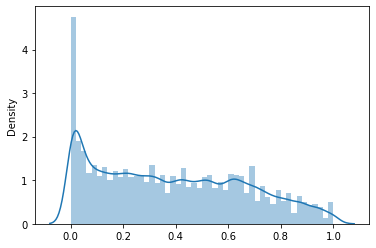

In [34]:
sns.distplot(df_n)

In [35]:
df_n.cov()

,registered,casual,hr,atemp,instant,temp,hum,cnt
registered,0.03,0.01,0.02,0.01,0.01,0.01,-0.01,0.03
casual,0.01,0.02,0.01,0.01,0.01,0.01,-0.01,0.02
hr,0.02,0.01,0.09,0.01,-0.00,0.01,-0.02,0.02
atemp,0.01,0.01,0.01,0.03,0.01,0.03,-0.00,0.01
instant,0.01,0.01,-0.00,0.01,0.08,0.01,0.00,0.01
temp,0.01,0.01,0.01,0.03,0.01,0.04,-0.00,0.01
hum,-0.01,-0.01,-0.02,-0.00,0.00,-0.00,0.04,-0.01
cnt,0.03,0.02,0.02,0.01,0.01,0.01,-0.01,0.03


In [36]:
mean=df_n.mean()

In [37]:
mean

registered   0.17
casual       0.10
hr           0.50
atemp        0.48
instant      0.50
temp         0.49
hum          0.63
cnt          0.19
dtype: float64

In [38]:
mode=df_n.mode().mean()
mode

registered   0.00
casual       0.00
hr           0.72
atemp        0.62
instant      0.50
temp         0.61
hum          0.88
cnt          0.00
dtype: float64

In [39]:
dfr.shape

(17379, 9)

# Part 1 Making datset on the basis of mean of columns and covariance matrix

In [42]:
df_n.head()

,registered,casual,hr,atemp,instant,temp,hum,cnt
0,0.01,0.01,0.00,0.29,0.00,0.22,0.81,0.02
1,0.04,0.02,0.04,0.27,0.00,0.20,0.80,0.04
2,0.03,0.01,0.09,0.27,0.00,0.20,0.80,0.03
3,0.01,0.01,0.13,0.29,0.00,0.22,0.75,0.01
4,0.00,0.00,0.17,0.29,0.00,0.22,0.75,0.00


In [41]:
random_seed=1000
cov = df_n.cov()
mean= df_n.mean()

# distr = multivariate_normal(cov = cov, mean = mean,
# 								seed = random_seed)

distr = multivariate_normal(cov = cov, mean = mean,
								seed = random_seed,allow_singular=True)


data = distr.rvs(size = df_n.shape[0])

### Generated data

In [43]:
df_g=pd.DataFrame(data)

In [44]:
df_g.head()

,0,1,2,3,4,5,6,7
0,0.21,0.18,0.68,0.60,0.69,0.63,0.63,0.26
1,0.06,0.01,0.46,0.31,0.41,0.31,0.40,0.06
2,0.24,0.09,0.46,0.32,0.81,0.30,0.47,0.25
3,0.07,0.25,0.10,0.56,0.77,0.58,0.61,0.15
4,0.11,0.02,0.71,0.62,0.55,0.69,0.82,0.11


In [45]:
df_g.columns = df_n.columns

In [46]:
df_g.head()

,registered,casual,hr,atemp,instant,temp,hum,cnt
0,0.21,0.18,0.68,0.60,0.69,0.63,0.63,0.26
1,0.06,0.01,0.46,0.31,0.41,0.31,0.40,0.06
2,0.24,0.09,0.46,0.32,0.81,0.30,0.47,0.25
3,0.07,0.25,0.10,0.56,0.77,0.58,0.61,0.15
4,0.11,0.02,0.71,0.62,0.55,0.69,0.82,0.11


<AxesSubplot:ylabel='Density'>

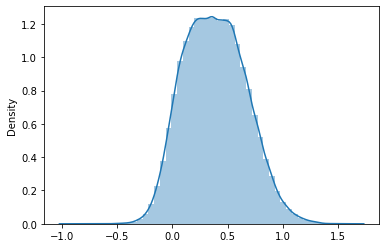

In [47]:
sns.distplot(df_g)

In [48]:
df_n.describe()

,registered,casual,hr,atemp,instant,temp,hum,cnt
count,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00
mean,0.17,0.10,0.50,0.48,0.50,0.49,0.63,0.19
std,0.17,0.13,0.30,0.17,0.29,0.20,0.19,0.19
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.04,0.01,0.26,0.33,0.25,0.33,0.48,0.04
50%,0.13,0.05,0.52,0.48,0.50,0.49,0.63,0.14
75%,0.25,0.13,0.78,0.62,0.75,0.65,0.78,0.29
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [49]:
df_g.describe()

,registered,casual,hr,atemp,instant,temp,hum,cnt
count,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00
mean,0.18,0.10,0.50,0.48,0.50,0.49,0.62,0.19
std,0.17,0.14,0.30,0.17,0.29,0.20,0.19,0.19
min,-0.53,-0.42,-0.62,-0.29,-0.94,-0.40,-0.14,-0.51
25%,0.06,0.01,0.30,0.36,0.31,0.36,0.49,0.07
50%,0.18,0.10,0.50,0.48,0.50,0.49,0.62,0.20
75%,0.29,0.19,0.71,0.59,0.70,0.62,0.76,0.32
max,0.90,0.68,1.65,1.13,1.60,1.23,1.37,0.95


# Finding probabbilties of all columns and joint probabilty on generated data set

#### Findining probabilities of all columns

In [51]:
df_g_prob=df_g.copy()

def f1(b):
    
    k=df_g[df_g[i] == b].shape[0]
    return(k/len(df_g))

for i in df_g.columns:
    # print(i)
    
    df_g_prob['prob_'+i] = df_g[i].apply(f1)

df_g_prob.head()



### Joint probability
df_g.columns

def f1(a):
    
    
    k=df_n[ (df_n[col[0]] == a[col[0]]) & (df_n[col[1]] == a[col[1]]) & (df_n[col[2]] == a[col[2]]) 
        & (df_n[col[3]] == a[col[3]]) & (df_n[col[4]] == a[col[4]]) & (df_n[col[5]] == a[col[5]])  
        & (df_n[col[6]] == a[col[6]]) & (df_n[col[7]] == a[col[7]]) ].shape[0]
   
    
    return(k/len(df_g))
    

df_g_prob['prob_joint'] = df_g.apply(f1,axis=1)

print('done')

# df_g
df_g_prob.head()
df_g_prob.prob_joint.unique()

done


array([0.])

#### This shows that all the rows in dataset are unique and hence the ombined joint probability is same for all rows

## Use model on new generated dataset

### Again creating smaller smaple dataset for running lazy predic models on generated dataste

In [52]:
df_gp=df_g.sample(frac =.1)
print(df_gp.shape)

(1738, 8)


In [53]:
X= df_gp.drop(columns='cnt')
X
y=df_gp['cnt']
y
offset = int(X.shape[0] * 0.9)

### splitting dataset into training and testing part.
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

reg = LazyRegressor(verbose=10, ignore_warnings=False, custom_metric=None)



### fitting data in LazyClassifier
models_1, predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models_1)

  5%|▍         | 2/42 [00:00<00:06,  6.03it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9709485423948779, 'Adjusted R-Squared': 0.9697234809296017, 'RMSE': 0.03509888548285439, 'Time taken': 0.2449512481689453}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9981848238892729, 'Adjusted R-Squared': 0.9981082803183386, 'RMSE': 0.00877341648319295, 'Time taken': 0.10939502716064453}
{'Model': 'BayesianRidge', 'R-Squared': 0.9999999999999994, 'Adjusted R-Squared': 0.9999999999999994, 'RMSE': 4.7368161300436116e-09, 'Time taken': 0.011005401611328125}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9957686663508255, 'Adjusted R-Squared': 0.9955902366186314, 'RMSE': 0.013395162869298233, 'Time taken': 0.014125347137451172}
{'Model': 'DummyRegressor', 'R-Squared': -0.0011181603857339795, 'Adjusted R-Squared': -0.04333398642609643, 'RMSE': 0.20604023305274438, 'Time taken': 0.0071582794189453125}
{'Model': 'ElasticNet', 'R-Squared': -0.0011181603857339795, 'Adjusted R-Squared': -0.04333398642609643, 'RMSE': 0.20604023305274438, 'Time t

 17%|█▋        | 7/42 [00:00<00:01, 20.31it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.9999984390289588, 'Adjusted R-Squared': 0.9999983732048787, 'RMSE': 0.00025728044944705393, 'Time taken': 0.06381440162658691}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.9925465134303576, 'Adjusted R-Squared': 0.9922322097798305, 'RMSE': 0.017778253694863713, 'Time taken': 0.02195286750793457}


 24%|██▍       | 10/42 [00:00<00:02, 12.43it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9995140730011403, 'Adjusted R-Squared': 0.999493582103598, 'RMSE': 0.004539362624958873, 'Time taken': 0.3481888771057129}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.9657676798950747, 'Adjusted R-Squared': 0.9643241483243851, 'RMSE': 0.03810022408122123, 'Time taken': 1.0544230937957764}


 29%|██▊       | 12/42 [00:02<00:07,  4.12it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9986505344314509, 'Adjusted R-Squared': 0.9985936292568736, 'RMSE': 0.0075646748683997345, 'Time taken': 0.26268506050109863}


 33%|███▎      | 14/42 [00:02<00:07,  3.68it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9964995605002426, 'Adjusted R-Squared': 0.9963519516056745, 'RMSE': 0.012183460246717247, 'Time taken': 0.6182756423950195}
{'Model': 'HuberRegressor', 'R-Squared': 0.9999999999999994, 'Adjusted R-Squared': 0.9999999999999994, 'RMSE': 4.732779957317753e-09, 'Time taken': 0.071441650390625}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9482054279081247, 'Adjusted R-Squared': 0.9460213194464191, 'RMSE': 0.04686530927292802, 'Time taken': 0.016561508178710938}


 55%|█████▍    | 23/42 [00:03<00:02,  7.64it/s]

{'Model': 'KernelRidge', 'R-Squared': 0.0854249621774702, 'Adjusted R-Squared': 0.04685854491989361, 'RMSE': 0.19693324380585459, 'Time taken': 0.7194032669067383}
{'Model': 'Lars', 'R-Squared': 0.9999999999999994, 'Adjusted R-Squared': 0.9999999999999994, 'RMSE': 4.739867057474183e-09, 'Time taken': 0.008998632431030273}
{'Model': 'LarsCV', 'R-Squared': 0.9999999999999994, 'Adjusted R-Squared': 0.9999999999999994, 'RMSE': 4.739867057474183e-09, 'Time taken': 0.012934207916259766}
{'Model': 'Lasso', 'R-Squared': -0.0011181603857339795, 'Adjusted R-Squared': -0.04333398642609643, 'RMSE': 0.20604023305274438, 'Time taken': 0.008000850677490234}
{'Model': 'LassoCV', 'R-Squared': 0.9999987333753079, 'Adjusted R-Squared': 0.9999986799634233, 'RMSE': 0.00023175725466498764, 'Time taken': 0.042836904525756836}
{'Model': 'LassoLars', 'R-Squared': -0.0011181603857339795, 'Adjusted R-Squared': -0.04333398642609643, 'RMSE': 0.20604023305274438, 'Time taken': 0.007234334945678711}
{'Model': 'Lasso

 62%|██████▏   | 26/42 [00:03<00:01,  8.75it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.9462100771261941, 'Adjusted R-Squared': 0.9439418273664553, 'RMSE': 0.047759505714893895, 'Time taken': 0.18846678733825684}


 69%|██████▉   | 29/42 [00:06<00:03,  3.56it/s]

{'Model': 'NuSVR', 'R-Squared': 0.9975743440928969, 'Adjusted R-Squared': 0.997472057398019, 'RMSE': 0.0101420082512171, 'Time taken': 2.1355364322662354}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9568922054352382, 'Adjusted R-Squared': 0.9550744068692543, 'RMSE': 0.042755034862936754, 'Time taken': 0.010210990905761719}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9999999999999994, 'Adjusted R-Squared': 0.9999999999999994, 'RMSE': 4.732321214966751e-09, 'Time taken': 0.013130664825439453}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9763679838549342, 'Adjusted R-Squared': 0.9753714530536363, 'RMSE': 0.03165627062385649, 'Time taken': 0.007997274398803711}
PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range for family PoissonDistribution


 76%|███████▌  | 32/42 [03:31<03:15, 19.55s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.0009476720657211057, 'Adjusted R-Squared': -0.043156308839576996, 'RMSE': 0.2060226881962836, 'Time taken': 205.6309552192688}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9999999999999994, 'Adjusted R-Squared': 0.9999999999999994, 'RMSE': 4.735145953912274e-09, 'Time taken': 0.012921810150146484}


 95%|█████████▌| 40/42 [03:32<00:16,  8.13s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9985854028169513, 'Adjusted R-Squared': 0.9985257511285095, 'RMSE': 0.007745077308841779, 'Time taken': 0.8111870288848877}
{'Model': 'Ridge', 'R-Squared': 0.9999996264791348, 'Adjusted R-Squared': 0.9999996107282549, 'RMSE': 0.00012585393419258672, 'Time taken': 0.018731355667114258}
{'Model': 'RidgeCV', 'R-Squared': 0.9999999962546982, 'Adjusted R-Squared': 0.9999999960967637, 'RMSE': 1.2602385930517658e-05, 'Time taken': 0.021174192428588867}
{'Model': 'SGDRegressor', 'R-Squared': 0.9999996457831802, 'Adjusted R-Squared': 0.9999996308463264, 'RMSE': 0.00012255864546254023, 'Time taken': 0.014352083206176758}
{'Model': 'SVR', 'R-Squared': 0.9459538467093686, 'Adjusted R-Squared': 0.9436747920525347, 'RMSE': 0.047873122714431546, 'Time taken': 0.022477149963378906}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9999999999999994, 'Adjusted R-Squared': 0.9999999999999994, 'RMSE': 4.735145953912274e-09, 'Time taken': 0.01109409332

100%|██████████| 42/42 [03:32<00:00,  5.07s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.9985435392820798, 'Adjusted R-Squared': 0.9984821222638542, 'RMSE': 0.007858845493606114, 'Time taken': 0.1816272735595703}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9964380729386997, 'Adjusted R-Squared': 0.9962878711951508, 'RMSE': 0.012289999738942408, 'Time taken': 0.10146045684814453}
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
LassoLarsCV                                  1.00       1.00  0.00        0.01
HuberRegressor                               1.00       1.00  0.00        0.07
LassoLarsIC                                  1.00       1.00  0.00        0.01
OrthogonalMatchingPursuitCV                  1.00       1.00  0.00        0.01
LarsCV                                       1.00       1.00  0.00        0.01
Lars                                         1.00       1.00  0.00        0.01
RANSACRegressor                     

# Part 2- Making multivariate gausian based on mean of the modes of columns and covariance matrix

In [54]:
random_seed=1000
cov = df_n.cov()
# mean= df_n.mean()

mode=df_n.mode().mean()
# mode

# distr = multivariate_normal(cov = cov, mean = mode,
# 								seed = random_seed)

distr = multivariate_normal(cov = cov, mean = mean,
								seed = random_seed,allow_singular=True)


data = distr.rvs(size = df_n.shape[0])

### Generated data

In [55]:
df_g=pd.DataFrame(data)

In [56]:
df_g.head()

,0,1,2,3,4,5,6,7
0,0.21,0.18,0.68,0.60,0.69,0.63,0.63,0.26
1,0.06,0.01,0.46,0.31,0.41,0.31,0.40,0.06
2,0.24,0.09,0.46,0.32,0.81,0.30,0.47,0.25
3,0.07,0.25,0.10,0.56,0.77,0.58,0.61,0.15
4,0.11,0.02,0.71,0.62,0.55,0.69,0.82,0.11


In [57]:
df_g.columns = df_n.columns

In [58]:
df_g.head()

,registered,casual,hr,atemp,instant,temp,hum,cnt
0,0.21,0.18,0.68,0.60,0.69,0.63,0.63,0.26
1,0.06,0.01,0.46,0.31,0.41,0.31,0.40,0.06
2,0.24,0.09,0.46,0.32,0.81,0.30,0.47,0.25
3,0.07,0.25,0.10,0.56,0.77,0.58,0.61,0.15
4,0.11,0.02,0.71,0.62,0.55,0.69,0.82,0.11


<AxesSubplot:ylabel='Density'>

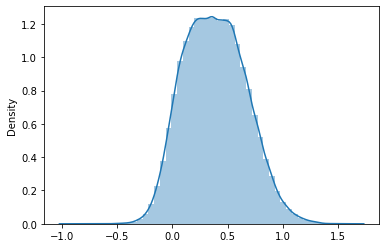

In [59]:
sns.distplot(df_g)

In [60]:
df_n.describe()

,registered,casual,hr,atemp,instant,temp,hum,cnt
count,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00
mean,0.17,0.10,0.50,0.48,0.50,0.49,0.63,0.19
std,0.17,0.13,0.30,0.17,0.29,0.20,0.19,0.19
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.04,0.01,0.26,0.33,0.25,0.33,0.48,0.04
50%,0.13,0.05,0.52,0.48,0.50,0.49,0.63,0.14
75%,0.25,0.13,0.78,0.62,0.75,0.65,0.78,0.29
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [61]:
df_g.describe()

,registered,casual,hr,atemp,instant,temp,hum,cnt
count,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00
mean,0.18,0.10,0.50,0.48,0.50,0.49,0.62,0.19
std,0.17,0.14,0.30,0.17,0.29,0.20,0.19,0.19
min,-0.53,-0.42,-0.62,-0.29,-0.94,-0.40,-0.14,-0.51
25%,0.06,0.01,0.30,0.36,0.31,0.36,0.49,0.07
50%,0.18,0.10,0.50,0.48,0.50,0.49,0.62,0.20
75%,0.29,0.19,0.71,0.59,0.70,0.62,0.76,0.32
max,0.90,0.68,1.65,1.13,1.60,1.23,1.37,0.95


# Finding probabbilties of all columns and joint probabilty on generated data set

#### Findining probabilities of all columns

In [62]:
df_g_prob=df_g.copy()

def f1(b):
    
    k=df_g[df_g[i] == b].shape[0]
    return(k/len(df_g))

for i in df_g.columns:
    # print(i)
    
    df_g_prob['prob_'+i] = df_g[i].apply(f1)

df_g_prob.head()



### Joint probability
df_g.columns

def f1(a):
    
    k=df_n[ (df_n[col[0]] == a[col[0]]) & (df_n[col[1]] == a[col[1]]) & (df_n[col[2]] == a[col[2]]) 
        & (df_n[col[3]] == a[col[3]]) & (df_n[col[4]] == a[col[4]]) & (df_n[col[5]] == a[col[5]])  
        & (df_n[col[6]] == a[col[6]]) & (df_n[col[7]] == a[col[7]]) ].shape[0]
   
    
    return(k/len(df_g))
    

df_g_prob['prob_joint'] = df_g.apply(f1,axis=1)

print('done')

# df_g
df_g_prob.head()
df_g_prob.prob_joint.unique()

done


array([0.])

#### This shows that all the rows in dataset are unique and hence the ombined joint probability is same for all rows

## Use model on new generated dataset

### Again creating smaller smaple dataset for running lazy predic models on generated dataste

In [63]:
df_gp=df_g.sample(frac =.1)
print(df_gp.shape)

(1738, 8)


In [65]:
X= df_gp.drop(columns='cnt')
X
y=df_gp['cnt']
y
offset = int(X.shape[0] * 0.9)

### splitting dataset into training and testing part.
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

reg = LazyRegressor(verbose=10, ignore_warnings=False, custom_metric=None)


### fitting data in LazyClassifier
models_2, predictions = reg.fit(X_train, X_test, y_train, y_test)
print(models_2)

 12%|█▏        | 5/42 [00:00<00:01, 21.13it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9834687021119879, 'Adjusted R-Squared': 0.9827715991889995, 'RMSE': 0.023933278932268993, 'Time taken': 0.16659212112426758}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9957721136962596, 'Adjusted R-Squared': 0.9955938293340537, 'RMSE': 0.012103483329132976, 'Time taken': 0.06667542457580566}
{'Model': 'BayesianRidge', 'R-Squared': 0.9999999999999993, 'Adjusted R-Squared': 0.9999999999999993, 'RMSE': 4.947960020222331e-09, 'Time taken': 0.010067224502563477}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9901704481254114, 'Adjusted R-Squared': 0.989755948949977, 'RMSE': 0.018455065289034803, 'Time taken': 0.018050670623779297}
{'Model': 'DummyRegressor', 'R-Squared': -0.0009756042863389158, 'Adjusted R-Squared': -0.04318541892491945, 'RMSE': 0.18623464394825073, 'Time taken': 0.009997129440307617}
{'Model': 'ElasticNet', 'R-Squared': -0.0009756042863389158, 'Adjusted R-Squared': -0.04318541892491945, 'RMSE': 0.18623464394825073, 'Time t

 21%|██▏       | 9/42 [00:00<00:02, 13.56it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9984437588199231, 'Adjusted R-Squared': 0.9983781341918475, 'RMSE': 0.007343230793018089, 'Time taken': 0.3203589916229248}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


 26%|██▌       | 11/42 [00:01<00:06,  5.14it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.9373333994154627, 'Adjusted R-Squared': 0.9346908319209339, 'RMSE': 0.046597948252791815, 'Time taken': 0.999908447265625}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9983279577791142, 'Adjusted R-Squared': 0.9982574499746191, 'RMSE': 0.007611536709898591, 'Time taken': 0.25177550315856934}


 31%|███       | 13/42 [00:02<00:07,  3.83it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9936426643674773, 'Adjusted R-Squared': 0.9933745839492384, 'RMSE': 0.014841790489013238, 'Time taken': 0.5990910530090332}
{'Model': 'HuberRegressor', 'R-Squared': 0.9999999999999993, 'Adjusted R-Squared': 0.9999999999999993, 'RMSE': 4.941607640304565e-09, 'Time taken': 0.07613062858581543}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9500578194830513, 'Adjusted R-Squared': 0.9479518239190836, 'RMSE': 0.04159896032381776, 'Time taken': 0.019501686096191406}


 52%|█████▏    | 22/42 [00:03<00:02,  7.24it/s]

{'Model': 'KernelRidge', 'R-Squared': -0.039725300469494185, 'Adjusted R-Squared': -0.08356913844109948, 'RMSE': 0.18980516771466743, 'Time taken': 0.7380819320678711}
{'Model': 'Lars', 'R-Squared': 0.9999999999999993, 'Adjusted R-Squared': 0.9999999999999993, 'RMSE': 4.941612038520084e-09, 'Time taken': 0.00944375991821289}
{'Model': 'LarsCV', 'R-Squared': 0.9999999999999993, 'Adjusted R-Squared': 0.9999999999999993, 'RMSE': 4.941612038520084e-09, 'Time taken': 0.01418304443359375}
{'Model': 'Lasso', 'R-Squared': -0.0009756042863389158, 'Adjusted R-Squared': -0.04318541892491945, 'RMSE': 0.18623464394825073, 'Time taken': 0.00892496109008789}
{'Model': 'LassoCV', 'R-Squared': 0.9999987669229499, 'Adjusted R-Squared': 0.9999987149257249, 'RMSE': 0.00020670159786602516, 'Time taken': 0.053288936614990234}
{'Model': 'LassoLars', 'R-Squared': -0.0009756042863389158, 'Adjusted R-Squared': -0.04318541892491945, 'RMSE': 0.18623464394825073, 'Time taken': 0.010066747665405273}
{'Model': 'Lass

 62%|██████▏   | 26/42 [00:03<00:01,  8.82it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.929744290513342, 'Adjusted R-Squared': 0.926781700354266, 'RMSE': 0.04933890859611414, 'Time taken': 0.21555733680725098}


 67%|██████▋   | 28/42 [00:05<00:04,  3.37it/s]

{'Model': 'NuSVR', 'R-Squared': 0.9972657987766463, 'Adjusted R-Squared': 0.9971505011346977, 'RMSE': 0.009733386368343956, 'Time taken': 2.1353847980499268}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.946875803436811, 'Adjusted R-Squared': 0.944635626473303, 'RMSE': 0.042903716471951125, 'Time taken': 0.008002042770385742}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9999999999999993, 'Adjusted R-Squared': 0.9999999999999993, 'RMSE': 4.929222031195277e-09, 'Time taken': 0.010915040969848633}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9691646990872247, 'Adjusted R-Squared': 0.9678644153137944, 'RMSE': 0.0326868313251338, 'Time taken': 0.005982875823974609}
PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range for family PoissonDistribution


 76%|███████▌  | 32/42 [03:15<02:49, 16.98s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.0009581374862528413, 'Adjusted R-Squared': -0.04316721557302272, 'RMSE': 0.18623301906475115, 'Time taken': 189.80428457260132}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9999999999999993, 'Adjusted R-Squared': 0.9999999999999993, 'RMSE': 4.944350482572259e-09, 'Time taken': 0.009018659591674805}


 81%|████████  | 34/42 [03:16<01:48, 13.61s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9966128948650715, 'Adjusted R-Squared': 0.9964700651304661, 'RMSE': 0.010833357251122172, 'Time taken': 0.5539531707763672}
{'Model': 'Ridge', 'R-Squared': 0.999999677032451, 'Adjusted R-Squared': 0.9999996634133375, 'RMSE': 0.00010578599378514867, 'Time taken': 0.008917093276977539}
{'Model': 'RidgeCV', 'R-Squared': 0.999999996763257, 'Adjusted R-Squared': 0.9999999966267679, 'RMSE': 1.0590167701937354e-05, 'Time taken': 0.011083841323852539}
{'Model': 'SGDRegressor', 'R-Squared': 0.9999998007386985, 'Adjusted R-Squared': 0.9999997923361136, 'RMSE': 8.309219043165743e-05, 'Time taken': 0.007993698120117188}
{'Model': 'SVR', 'R-Squared': 0.9445427118710445, 'Adjusted R-Squared': 0.9422041515282573, 'RMSE': 0.0438357095623025, 'Time taken': 0.012000322341918945}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9999999999999993, 'Adjusted R-Squared': 0.9999999999999993, 'RMSE': 4.944350482572259e-09, 'Time taken': 0.0089204311370849

100%|██████████| 42/42 [03:16<00:00,  4.68s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.9976592259429589, 'Adjusted R-Squared': 0.9975605186032042, 'RMSE': 0.009005928075504233, 'Time taken': 0.17694616317749023}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9934072691832263, 'Adjusted R-Squared': 0.993129262462037, 'RMSE': 0.015114068922305468, 'Time taken': 0.15532231330871582}
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
LassoLarsCV                                  1.00       1.00  0.00        0.02
HuberRegressor                               1.00       1.00  0.00        0.08
LassoLarsIC                                  1.00       1.00  0.00        0.01
OrthogonalMatchingPursuitCV                  1.00       1.00  0.00        0.01
LarsCV                                       1.00       1.00  0.00        0.01
Lars                                         1.00       1.00  0.00        0.01
RANSACRegressor                     

# Part 3- Making multivariate gausian based on mean of the modes of columns and corelation matrix

In [66]:
random_seed=1000
# cov = df_n.cov()

cov = df_n.corr()
# mean= df_n.mean()

mode=df_n.mode().mean()
# mode

# distr = multivariate_normal(cov = cov, mean = mode,
# 								seed = random_seed)

distr = multivariate_normal(cov = cov, mean = mean,
								seed = random_seed,allow_singular=True)


data = distr.rvs(size = df_n.shape[0])

### Generated data

In [67]:
df_g=pd.DataFrame(data)

In [68]:
df_g.head()

,0,1,2,3,4,5,6,7
0,0.79,1.13,0.57,0.79,0.73,0.79,-0.12,0.99
1,0.27,-0.66,-0.41,0.19,0.18,0.15,1.98,0.07
2,1.10,-0.04,0.77,-0.17,1.23,-0.11,1.37,0.93
3,0.13,0.98,1.06,-0.91,-0.44,-0.90,0.50,0.40
4,0.19,0.40,-0.30,0.98,0.67,0.77,-0.90,0.29


In [69]:
df_g.columns = df_n.columns

In [70]:
df_g.head()

,registered,casual,hr,atemp,instant,temp,hum,cnt
0,0.79,1.13,0.57,0.79,0.73,0.79,-0.12,0.99
1,0.27,-0.66,-0.41,0.19,0.18,0.15,1.98,0.07
2,1.10,-0.04,0.77,-0.17,1.23,-0.11,1.37,0.93
3,0.13,0.98,1.06,-0.91,-0.44,-0.90,0.50,0.40
4,0.19,0.40,-0.30,0.98,0.67,0.77,-0.90,0.29


<AxesSubplot:ylabel='Density'>

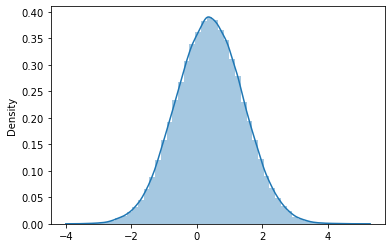

In [71]:
sns.distplot(df_g)

In [72]:
df_n.describe()

,registered,casual,hr,atemp,instant,temp,hum,cnt
count,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00
mean,0.17,0.10,0.50,0.48,0.50,0.49,0.63,0.19
std,0.17,0.13,0.30,0.17,0.29,0.20,0.19,0.19
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.04,0.01,0.26,0.33,0.25,0.33,0.48,0.04
50%,0.13,0.05,0.52,0.48,0.50,0.49,0.63,0.14
75%,0.25,0.13,0.78,0.62,0.75,0.65,0.78,0.29
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [73]:
df_g.describe()

,registered,casual,hr,atemp,instant,temp,hum,cnt
count,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00
mean,0.19,0.10,0.51,0.48,0.50,0.49,0.62,0.21
std,1.01,1.00,1.01,0.99,1.01,1.00,1.01,1.01
min,-3.63,-3.49,-3.30,-3.12,-3.24,-3.19,-3.15,-3.71
25%,-0.49,-0.58,-0.18,-0.19,-0.19,-0.18,-0.06,-0.48
50%,0.19,0.11,0.49,0.48,0.50,0.50,0.62,0.21
75%,0.87,0.79,1.20,1.16,1.18,1.17,1.30,0.89
max,4.86,4.14,4.23,4.26,4.77,4.23,4.65,5.00


# Finding probabbilties of all columns and joint probabilty on generated data set

#### Findining probabilities of all columns

In [75]:
df_g_prob=df_g.copy()

def f1(b):
    
    k=df_g[df_g[i] == b].shape[0]
    return(k/len(df_g))

for i in df_g.columns:
    # print(i)
    
    df_g_prob['prob_'+i] = df_g[i].apply(f1)

df_g_prob.head()



### Joint probability
df_g.columns

def f1(a):
    
    k=df_n[ (df_n[col[0]] == a[col[0]]) & (df_n[col[1]] == a[col[1]]) & (df_n[col[2]] == a[col[2]]) 
        & (df_n[col[3]] == a[col[3]]) & (df_n[col[4]] == a[col[4]]) & (df_n[col[5]] == a[col[5]])  
        & (df_n[col[6]] == a[col[6]]) & (df_n[col[7]] == a[col[7]]) ].shape[0]
    
    
    return(k/len(df_g))
    

df_g_prob['prob_joint'] = df_g.apply(f1,axis=1)

print('done')

# df_g
df_g_prob.head()
df_g_prob.prob_joint.unique()

done


array([0.])

#### This shows that all the rows in dataset are unique and hence the ombined joint probability is same for all rows

## Use model on new generated dataset

### Again creating smaller smaple dataset for running lazy predic models on generated dataste

In [76]:
df_gp=df_g.sample(frac =.1)
print(df_gp.shape)

(1738, 8)


In [77]:
X= df_gp.drop(columns='cnt')
X
y=df_gp['cnt']
y
offset = int(X.shape[0] * 0.9)

### splitting dataset into training and testing part.
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

reg = LazyRegressor(verbose=10, ignore_warnings=False, custom_metric=None)



### fitting data in LazyClassifier
models_3, predictions = reg.fit(X_train, X_test, y_train, y_test)
print(models_3)

 10%|▉         | 4/42 [00:00<00:03, 12.23it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9717006868505067, 'Adjusted R-Squared': 0.9705073423201064, 'RMSE': 0.17044757693860196, 'Time taken': 0.2811086177825928}
{'Model': 'BaggingRegressor', 'R-Squared': 0.997805382761468, 'Adjusted R-Squared': 0.997712838661048, 'RMSE': 0.04746596092571111, 'Time taken': 0.07850766181945801}
{'Model': 'BayesianRidge', 'R-Squared': 0.9999999999999981, 'Adjusted R-Squared': 0.999999999999998, 'RMSE': 4.4549412559345185e-08, 'Time taken': 0.00899052619934082}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9923375545793244, 'Adjusted R-Squared': 0.9920144394109827, 'RMSE': 0.08869243560046491, 'Time taken': 0.016269683837890625}
{'Model': 'DummyRegressor', 'R-Squared': -0.0010533092322670967, 'Adjusted R-Squared': -0.04326640058543507, 'RMSE': 1.0137514469345066, 'Time taken': 0.011933565139770508}
{'Model': 'ElasticNet', 'R-Squared': 0.5379245447509353, 'Adjusted R-Squared': 0.5184394351922398, 'RMSE': 0.6887463880196856, 'Time taken': 0.01500

 19%|█▉        | 8/42 [00:00<00:01, 21.09it/s]

{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.9921806659662882, 'Adjusted R-Squared': 0.9918509350130593, 'RMSE': 0.08959582387005507, 'Time taken': 0.012130022048950195}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9995261112342969, 'Adjusted R-Squared': 0.9995061279730926, 'RMSE': 0.022056728166814553, 'Time taken': 0.3519446849822998}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


 26%|██▌       | 11/42 [00:01<00:06,  4.72it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.964808539876133, 'Adjusted R-Squared': 0.9633245626419941, 'RMSE': 0.19007348058689505, 'Time taken': 1.0379531383514404}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9985375853088093, 'Adjusted R-Squared': 0.9984759172194217, 'RMSE': 0.0387470064381944, 'Time taken': 0.2716646194458008}


 31%|███       | 13/42 [00:02<00:07,  3.74it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9980567778004126, 'Adjusted R-Squared': 0.9979748346956107, 'RMSE': 0.04466466859087988, 'Time taken': 0.5599439144134521}
{'Model': 'HuberRegressor', 'R-Squared': 0.9999999999999981, 'Adjusted R-Squared': 0.999999999999998, 'RMSE': 4.4539390089684104e-08, 'Time taken': 0.0680091381072998}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9535472006981153, 'Adjusted R-Squared': 0.9515883477155057, 'RMSE': 0.2183779724292219, 'Time taken': 0.016411542892456055}


 52%|█████▏    | 22/42 [00:03<00:02,  7.16it/s]

{'Model': 'KernelRidge', 'R-Squared': 0.9432501797147904, 'Adjusted R-Squared': 0.9408571150039683, 'RMSE': 0.24137102213421274, 'Time taken': 0.7109498977661133}
{'Model': 'Lars', 'R-Squared': 0.9999999999999981, 'Adjusted R-Squared': 0.999999999999998, 'RMSE': 4.433876201204039e-08, 'Time taken': 0.009232521057128906}
{'Model': 'LarsCV', 'R-Squared': 0.9999999999999981, 'Adjusted R-Squared': 0.999999999999998, 'RMSE': 4.433876201204039e-08, 'Time taken': 0.01654338836669922}
{'Model': 'Lasso', 'R-Squared': -0.0010533092322670967, 'Adjusted R-Squared': -0.04326640058543507, 'RMSE': 1.0137514469345066, 'Time taken': 0.010437250137329102}
{'Model': 'LassoCV', 'R-Squared': 0.9999987377550335, 'Adjusted R-Squared': 0.999998684527836, 'RMSE': 0.001138347106684632, 'Time taken': 0.051073551177978516}
{'Model': 'LassoLars', 'R-Squared': -0.0010533092322670967, 'Adjusted R-Squared': -0.04326640058543507, 'RMSE': 1.0137514469345066, 'Time taken': 0.009985208511352539}
{'Model': 'LassoLarsCV', 

 62%|██████▏   | 26/42 [00:03<00:01,  8.59it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.996733147233073, 'Adjusted R-Squared': 0.9965953883814557, 'RMSE': 0.05791188019389859, 'Time taken': 0.2498002052307129}


 69%|██████▉   | 29/42 [00:04<00:01,  7.14it/s]

{'Model': 'NuSVR', 'R-Squared': 0.9966897900916294, 'Adjusted R-Squared': 0.9965502029268186, 'RMSE': 0.05829491205143868, 'Time taken': 0.6002357006072998}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9506836526213113, 'Adjusted R-Squared': 0.9486040476113665, 'RMSE': 0.22500819499902372, 'Time taken': 0.00902700424194336}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9999999999999981, 'Adjusted R-Squared': 0.999999999999998, 'RMSE': 4.457326886526861e-08, 'Time taken': 0.012039422988891602}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.999131968312795, 'Adjusted R-Squared': 0.999095364566949, 'RMSE': 0.029851810351919236, 'Time taken': 0.008075475692749023}
PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range for family PoissonDistribution


 76%|███████▌  | 32/42 [02:53<02:34, 15.40s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.0007843642773348591, 'Adjusted R-Squared': -0.04298611457818646, 'RMSE': 1.0136152595559833, 'Time taken': 169.37913179397583}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9999999999999981, 'Adjusted R-Squared': 0.999999999999998, 'RMSE': 4.4550158764939086e-08, 'Time taken': 0.01300358772277832}


 90%|█████████ | 38/42 [02:54<00:31,  7.79s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9986820039867935, 'Adjusted R-Squared': 0.9986264258416583, 'RMSE': 0.036784082888323966, 'Time taken': 0.8260331153869629}
{'Model': 'Ridge', 'R-Squared': 0.9999996069761373, 'Adjusted R-Squared': 0.9999995904028419, 'RMSE': 0.0006352027126589052, 'Time taken': 0.014100790023803711}
{'Model': 'RidgeCV', 'R-Squared': 0.9999999960618129, 'Adjusted R-Squared': 0.9999999958957447, 'RMSE': 6.358446994372535e-05, 'Time taken': 0.012610197067260742}
{'Model': 'SGDRegressor', 'R-Squared': 0.9999997912383732, 'Adjusted R-Squared': 0.9999997824351721, 'RMSE': 0.0004629437449668075, 'Time taken': 0.01657271385192871}
{'Model': 'SVR', 'R-Squared': 0.9916248237203681, 'Adjusted R-Squared': 0.9912716536362872, 'RMSE': 0.09272564493495403, 'Time taken': 0.08692502975463867}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9999999999999981, 'Adjusted R-Squared': 0.999999999999998, 'RMSE': 4.4550158764939086e-08, 'Time taken': 0.01501274108886718

100%|██████████| 42/42 [02:55<00:00,  4.17s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.998064342825515, 'Adjusted R-Squared': 0.9979827187277958, 'RMSE': 0.04457764333090474, 'Time taken': 0.2480027675628662}
{'Model': 'LGBMRegressor', 'R-Squared': 0.997923118578182, 'Adjusted R-Squared': 0.9978355392411173, 'RMSE': 0.04617519466523246, 'Time taken': 0.16490602493286133}
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
LassoLarsCV                                  1.00       1.00  0.00        0.01
LinearRegression                             1.00       1.00  0.00        0.01
OrthogonalMatchingPursuitCV                  1.00       1.00  0.00        0.01
LarsCV                                       1.00       1.00  0.00        0.02
Lars                                         1.00       1.00  0.00        0.01
RANSACRegressor                              1.00       1.00  0.00        0.01
HuberRegressor                          

# Part 4- Making multivariate gausian based on mean  of columns and corelation matrix

In [78]:
random_seed=1000
# cov = df_n.cov()

cov = df_n.corr()
mean= df_n.mean()

# mode=df_n.mode().mean()
# mode

# distr = multivariate_normal(cov = cov, mean = mean,
# 								seed = random_seed)

distr = multivariate_normal(cov = cov, mean = mean,
								seed = random_seed,allow_singular=True)


data = distr.rvs(size = df_n.shape[0])

### Generated data

In [79]:
df_g=pd.DataFrame(data)

In [80]:
df_g.head()

,0,1,2,3,4,5,6,7
0,0.79,1.13,0.57,0.79,0.73,0.79,-0.12,0.99
1,0.27,-0.66,-0.41,0.19,0.18,0.15,1.98,0.07
2,1.10,-0.04,0.77,-0.17,1.23,-0.11,1.37,0.93
3,0.13,0.98,1.06,-0.91,-0.44,-0.90,0.50,0.40
4,0.19,0.40,-0.30,0.98,0.67,0.77,-0.90,0.29


In [81]:
df_g.columns = df_n.columns

In [82]:
df_g.head()

,registered,casual,hr,atemp,instant,temp,hum,cnt
0,0.79,1.13,0.57,0.79,0.73,0.79,-0.12,0.99
1,0.27,-0.66,-0.41,0.19,0.18,0.15,1.98,0.07
2,1.10,-0.04,0.77,-0.17,1.23,-0.11,1.37,0.93
3,0.13,0.98,1.06,-0.91,-0.44,-0.90,0.50,0.40
4,0.19,0.40,-0.30,0.98,0.67,0.77,-0.90,0.29


<AxesSubplot:ylabel='Density'>

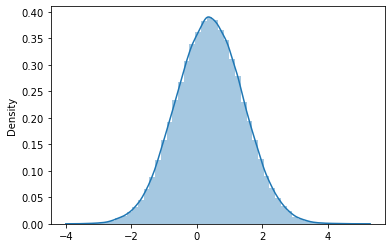

In [83]:
sns.distplot(df_g)

In [84]:
df_n.describe()

,registered,casual,hr,atemp,instant,temp,hum,cnt
count,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00
mean,0.17,0.10,0.50,0.48,0.50,0.49,0.63,0.19
std,0.17,0.13,0.30,0.17,0.29,0.20,0.19,0.19
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.04,0.01,0.26,0.33,0.25,0.33,0.48,0.04
50%,0.13,0.05,0.52,0.48,0.50,0.49,0.63,0.14
75%,0.25,0.13,0.78,0.62,0.75,0.65,0.78,0.29
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [85]:
df_g.describe()

,registered,casual,hr,atemp,instant,temp,hum,cnt
count,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00,17379.00
mean,0.19,0.10,0.51,0.48,0.50,0.49,0.62,0.21
std,1.01,1.00,1.01,0.99,1.01,1.00,1.01,1.01
min,-3.63,-3.49,-3.30,-3.12,-3.24,-3.19,-3.15,-3.71
25%,-0.49,-0.58,-0.18,-0.19,-0.19,-0.18,-0.06,-0.48
50%,0.19,0.11,0.49,0.48,0.50,0.50,0.62,0.21
75%,0.87,0.79,1.20,1.16,1.18,1.17,1.30,0.89
max,4.86,4.14,4.23,4.26,4.77,4.23,4.65,5.00


# Finding probabbilties of all columns and joint probabilty on generated data set

#### Findining probabilities of all columns

In [86]:
df_g_prob=df_g.copy()

def f1(b):
    
    k=df_g[df_g[i] == b].shape[0]
    return(k/len(df_g))

for i in df_g.columns:
    # print(i)
    
    df_g_prob['prob_'+i] = df_g[i].apply(f1)

df_g_prob.head()



### Joint probability
df_g.columns

def f1(a):
    
    k=df_n[ (df_n[col[0]] == a[col[0]]) & (df_n[col[1]] == a[col[1]]) & (df_n[col[2]] == a[col[2]]) 
        & (df_n[col[3]] == a[col[3]]) & (df_n[col[4]] == a[col[4]]) & (df_n[col[5]] == a[col[5]])  
        & (df_n[col[6]] == a[col[6]]) & (df_n[col[7]] == a[col[7]]) ].shape[0]
   
    
    return(k/len(df_g))
    

df_g_prob['prob_joint'] = df_g.apply(f1,axis=1)

print('done')

# df_g
df_g_prob.head()
df_g_prob.prob_joint.unique()

done


array([0.])

#### This shows that all the rows in dataset are unique and hence the ombined joint probability is same for all rows

## Use model on new generated dataset

### Again creating smaller smaple dataset for running lazy predic models on generated dataste

In [87]:
df_gp=df_g.sample(frac =.1)
print(df_gp.shape)

(1738, 8)


In [88]:
X= df_gp.drop(columns='cnt')
X
y=df_gp['cnt']
y
offset = int(X.shape[0] * 0.9)

### splitting dataset into training and testing part.
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

reg = LazyRegressor(verbose=10, ignore_warnings=False, custom_metric=None)


### fitting data in LazyClassifier
models_4, predictions = reg.fit(X_train, X_test, y_train, y_test)
print(models_4)

 14%|█▍        | 6/42 [00:00<00:01, 25.92it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9738283183092752, 'Adjusted R-Squared': 0.9727246931777386, 'RMSE': 0.1761422872595565, 'Time taken': 0.16181540489196777}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9965399395478793, 'Adjusted R-Squared': 0.9963940333842357, 'RMSE': 0.06404565328949939, 'Time taken': 0.06311941146850586}
{'Model': 'BayesianRidge', 'R-Squared': 0.9999999999999983, 'Adjusted R-Squared': 0.9999999999999982, 'RMSE': 4.4387951074699665e-08, 'Time taken': 0.008989810943603516}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9923443434580395, 'Adjusted R-Squared': 0.9920215145677158, 'RMSE': 0.09526624277786316, 'Time taken': 0.01599740982055664}
{'Model': 'DummyRegressor', 'R-Squared': -3.541040819809993e-05, 'Adjusted R-Squared': -0.04220557831697769, 'RMSE': 1.0888185363654945, 'Time taken': 0.009998321533203125}
{'Model': 'ElasticNet', 'R-Squared': 0.5235529125993852, 'Adjusted R-Squared': 0.5034617703596003, 'RMSE': 0.7515452856454972, 'Time taken': 0.00

 24%|██▍       | 10/42 [00:00<00:02, 14.35it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9993518491423695, 'Adjusted R-Squared': 0.9993245174796983, 'RMSE': 0.027719530280312585, 'Time taken': 0.3380701541900635}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.9172397564035136, 'Adjusted R-Squared': 0.9137498666133004, 'RMSE': 0.3132266436219086, 'Time taken': 1.098613977432251}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9986379263295531, 'Adjusted R-Squared': 0.9985804894880282, 'RMSE': 0.04018353278450769, 'Time taken': 0.2804851531982422}


 36%|███▌      | 15/42 [00:02<00:06,  4.47it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9961290585870507, 'Adjusted R-Squared': 0.9959658261178299, 'RMSE': 0.0677417038391152, 'Time taken': 0.6402792930603027}
{'Model': 'HuberRegressor', 'R-Squared': 0.9999999999999983, 'Adjusted R-Squared': 0.9999999999999982, 'RMSE': 4.445347553136126e-08, 'Time taken': 0.08813619613647461}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9400146686885951, 'Adjusted R-Squared': 0.9374851667658249, 'RMSE': 0.26666765853197333, 'Time taken': 0.018371105194091797}


 55%|█████▍    | 23/42 [00:03<00:02,  7.26it/s]

{'Model': 'KernelRidge', 'R-Squared': 0.9619300625665139, 'Adjusted R-Squared': 0.9603247037590777, 'RMSE': 0.2124412744963132, 'Time taken': 0.8076391220092773}
{'Model': 'Lars', 'R-Squared': 0.9999999999999983, 'Adjusted R-Squared': 0.9999999999999982, 'RMSE': 4.488409985940518e-08, 'Time taken': 0.009270191192626953}
{'Model': 'LarsCV', 'R-Squared': 0.9999999999999983, 'Adjusted R-Squared': 0.9999999999999982, 'RMSE': 4.488409985940518e-08, 'Time taken': 0.015512704849243164}
{'Model': 'Lasso', 'R-Squared': -3.541040819809993e-05, 'Adjusted R-Squared': -0.04220557831697769, 'RMSE': 1.0888185363654945, 'Time taken': 0.0069997310638427734}
{'Model': 'LassoCV', 'R-Squared': 0.9999987109719507, 'Adjusted R-Squared': 0.9999986566153463, 'RMSE': 0.0012361722795067084, 'Time taken': 0.05187582969665527}
{'Model': 'LassoLars', 'R-Squared': -3.541040819809993e-05, 'Adjusted R-Squared': -0.04220557831697769, 'RMSE': 1.0888185363654945, 'Time taken': 0.00991964340209961}
{'Model': 'LassoLarsCV

 62%|██████▏   | 26/42 [00:03<00:01,  8.09it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.9962742812251231, 'Adjusted R-Squared': 0.9961171726020861, 'RMSE': 0.0664588545667595, 'Time taken': 0.24187159538269043}


 69%|██████▉   | 29/42 [00:04<00:01,  6.63it/s]

{'Model': 'NuSVR', 'R-Squared': 0.9855651002774348, 'Adjusted R-Squared': 0.9849563996867242, 'RMSE': 0.13081414358034557, 'Time taken': 0.6379246711730957}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9488198901576247, 'Adjusted R-Squared': 0.946661692754633, 'RMSE': 0.24631928967332323, 'Time taken': 0.010120868682861328}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9999999999999983, 'Adjusted R-Squared': 0.9999999999999982, 'RMSE': 4.456635048553533e-08, 'Time taken': 0.012211322784423828}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9990714932317154, 'Adjusted R-Squared': 0.999032339331848, 'RMSE': 0.033177247576496746, 'Time taken': 0.007999658584594727}
PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range for family PoissonDistribution


 76%|███████▌  | 32/42 [02:57<02:45, 16.60s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -2.8862477661206754e-06, 'Adjusted R-Squared': -0.04217168265580451, 'RMSE': 1.0888008303941221, 'Time taken': 172.37882256507874}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9999999999999983, 'Adjusted R-Squared': 0.9999999999999982, 'RMSE': 4.438762457342465e-08, 'Time taken': 0.009001493453979492}


 95%|█████████▌| 40/42 [02:57<00:13,  6.83s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9971660794853009, 'Adjusted R-Squared': 0.9970465768129944, 'RMSE': 0.05796177133452078, 'Time taken': 0.5483477115631104}
{'Model': 'Ridge', 'R-Squared': 0.9999995671753953, 'Adjusted R-Squared': 0.9999995489237553, 'RMSE': 0.0007163145737767145, 'Time taken': 0.012235641479492188}
{'Model': 'RidgeCV', 'R-Squared': 0.9999999956614412, 'Adjusted R-Squared': 0.9999999954784898, 'RMSE': 7.171674343435795e-05, 'Time taken': 0.009857892990112305}
{'Model': 'SGDRegressor', 'R-Squared': 0.9999995776266606, 'Adjusted R-Squared': 0.9999995598157366, 'RMSE': 0.0007076134274554548, 'Time taken': 0.012091636657714844}
{'Model': 'SVR', 'R-Squared': 0.9781934321008494, 'Adjusted R-Squared': 0.977273878032813, 'RMSE': 0.16078349902759376, 'Time taken': 0.05199885368347168}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9999999999999983, 'Adjusted R-Squared': 0.9999999999999982, 'RMSE': 4.438762457342465e-08, 'Time taken': 0.008743047714233398

100%|██████████| 42/42 [02:57<00:00,  4.24s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.998007128371127, 'Adjusted R-Squared': 0.9979230916156926, 'RMSE': 0.04860573098567939, 'Time taken': 0.1731562614440918}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9962061914009126, 'Adjusted R-Squared': 0.9960462115202282, 'RMSE': 0.06706339341017423, 'Time taken': 0.11185860633850098}
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
LassoLarsCV                                  1.00       1.00  0.00        0.01
HuberRegressor                               1.00       1.00  0.00        0.09
LassoLarsIC                                  1.00       1.00  0.00        0.01
OrthogonalMatchingPursuitCV                  1.00       1.00  0.00        0.01
LarsCV                                       1.00       1.00  0.00        0.02
Lars                                         1.00       1.00  0.00        0.01
RANSACRegressor                        

# Comparing all models results of parts

In [89]:
print(models)

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
LassoLarsCV                                  1.00       1.00  0.00        0.01
OrthogonalMatchingPursuitCV                  1.00       1.00  0.00        0.01
LarsCV                                       1.00       1.00  0.00        0.01
Lars                                         1.00       1.00  0.00        0.01
LinearRegression                             1.00       1.00  0.00        0.01
HuberRegressor                               1.00       1.00  0.00        0.11
RANSACRegressor                              1.00       1.00  0.00        0.01
TransformedTargetRegressor                   1.00       1.00  0.00        0.01
BayesianRidge                                1.00       1.00  0.00        0.01
LassoLarsIC                                  1.00       1.00  0.00        0.01
LinearSVR                                    1.00   

In [90]:
print(models_1)

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
LassoLarsCV                                  1.00       1.00  0.00        0.01
HuberRegressor                               1.00       1.00  0.00        0.07
LassoLarsIC                                  1.00       1.00  0.00        0.01
OrthogonalMatchingPursuitCV                  1.00       1.00  0.00        0.01
LarsCV                                       1.00       1.00  0.00        0.01
Lars                                         1.00       1.00  0.00        0.01
RANSACRegressor                              1.00       1.00  0.00        0.01
LinearRegression                             1.00       1.00  0.00        0.01
TransformedTargetRegressor                   1.00       1.00  0.00        0.01
BayesianRidge                                1.00       1.00  0.00        0.01
LinearSVR                                    1.00   

In [91]:
print(models_2)

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
LassoLarsCV                                  1.00       1.00  0.00        0.02
HuberRegressor                               1.00       1.00  0.00        0.08
LassoLarsIC                                  1.00       1.00  0.00        0.01
OrthogonalMatchingPursuitCV                  1.00       1.00  0.00        0.01
LarsCV                                       1.00       1.00  0.00        0.01
Lars                                         1.00       1.00  0.00        0.01
RANSACRegressor                              1.00       1.00  0.00        0.01
LinearRegression                             1.00       1.00  0.00        0.01
TransformedTargetRegressor                   1.00       1.00  0.00        0.01
BayesianRidge                                1.00       1.00  0.00        0.01
LinearSVR                                    1.00   

In [92]:
print(models_3)

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
LassoLarsCV                                  1.00       1.00  0.00        0.01
LinearRegression                             1.00       1.00  0.00        0.01
OrthogonalMatchingPursuitCV                  1.00       1.00  0.00        0.01
LarsCV                                       1.00       1.00  0.00        0.02
Lars                                         1.00       1.00  0.00        0.01
RANSACRegressor                              1.00       1.00  0.00        0.01
HuberRegressor                               1.00       1.00  0.00        0.07
LassoLarsIC                                  1.00       1.00  0.00        0.01
TransformedTargetRegressor                   1.00       1.00  0.00        0.02
BayesianRidge                                1.00       1.00  0.00        0.01
LinearSVR                                    1.00   

In [93]:
print(models_4)

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
LassoLarsCV                                  1.00       1.00  0.00        0.01
HuberRegressor                               1.00       1.00  0.00        0.09
LassoLarsIC                                  1.00       1.00  0.00        0.01
OrthogonalMatchingPursuitCV                  1.00       1.00  0.00        0.01
LarsCV                                       1.00       1.00  0.00        0.02
Lars                                         1.00       1.00  0.00        0.01
RANSACRegressor                              1.00       1.00  0.00        0.01
LinearRegression                             1.00       1.00  0.00        0.01
TransformedTargetRegressor                   1.00       1.00  0.00        0.01
BayesianRidge                                1.00       1.00  0.00        0.01
LinearSVR                                    1.00   

#  gaussian estimate (part 3)

In [95]:
random_seed=1000
# cov = df_n.cov()

cov = df_n.corr()
# mean= df_n.mean()

mode=df_n.mode().mean()
# mode

# distr = multivariate_normal(cov = cov, mean = mode,
# 								seed = random_seed)

distr = multivariate_normal(cov = cov, mean = mean,
								seed = random_seed,allow_singular=True)


data = distr.rvs(size = df_n.shape[0])
### Generated data
df_g=pd.DataFrame(data)
df_g.head()
df_g.columns = df_n.columns
df_g.head()

,registered,casual,hr,atemp,instant,temp,hum,cnt
0,0.79,1.13,0.57,0.79,0.73,0.79,-0.12,0.99
1,0.27,-0.66,-0.41,0.19,0.18,0.15,1.98,0.07
2,1.10,-0.04,0.77,-0.17,1.23,-0.11,1.37,0.93
3,0.13,0.98,1.06,-0.91,-0.44,-0.90,0.50,0.40
4,0.19,0.40,-0.30,0.98,0.67,0.77,-0.90,0.29


# Joint distribution plot of original dataste and best generated dataset (part 3)

### Orginal dataset

<AxesSubplot:ylabel='Density'>

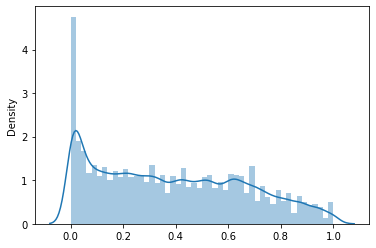

In [96]:
sns.distplot(df_n)

### Generated dataset of best model (part 3)

<AxesSubplot:ylabel='Density'>

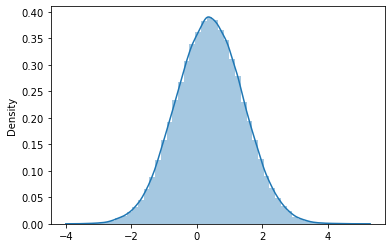

In [97]:
sns.distplot(df_g)

### the generated datset has a joint distribution plot which is gaussian

# Results

### It can be seen that all parts  performed best and has results of ML models result of R2adj = 1.0 which are all closest to results of original dataset this is due to the fact that joint distribution of datset was more gaussian

# Conclusion

### We have built a mutilvarite gausian on all the columns of dataset, we sued for variations and parts trying to best fit our dataset on multivariate gaussian

## Following conclusions were made:

## For original dataset:
#### The 8 columns are not purely gaussian and are mostly skewed and therefore its combined distribution plot is not pure Gaussian, the best result of ML model from lazy predit is R2adj = 1.0


## For part 1 (using mean of columns and covariance matrix):
### The comined distribution plot is purely gaussuian as shown in figure also, the best result of ML model from lazy predit is R2adj = 1.0


## For part 2 (using mean of mode of columns and covariance matrix):
### The comined distribution plot is purely gaussuian as shown in figure also, the best result of ML model from lazy predit is R2adj = 1.0


## For part 3 (using mean of mode of columns and correlation matrix):
### The comined distribution plot is purely gaussuian as shown in figure also, the best result of ML model from lazy predit is R2adj = 1.0


## For part 4 (using mean of  columns and correlation matrix):
### The comined distribution plot is purely gaussuian as shown in figure also, the best result of ML model from lazy predit is R2adj = 1.0

# Fututure Work:

### Can use best models of Lazy predict on complete dataset.
### Find ways of using implementing MLE and joint probabilities to find the mean and standard deviation of sample


# End